In [1]:
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, Input
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from sklearn.model_selection import train_test_split
from random import randint, random

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
image_size = (208,208)
batch_size = 32

In [3]:
def correct_data_car(image_size, df = None):
    boxes = []
    a,b = image_size
    if df is None:
        df = pd.read_csv('_annotations.csv') 
    for height, width, x1, y1, x2, y2 in zip(df['height'], df['width'], list(df['xmin'].apply(lambda x: int(x) / 416 * a)), list(df['ymin'].apply(lambda x: int(x) / 416 * a)), 
               list(df['xmax'].apply(lambda x: int(x) / 416 * a)), list(df['ymax'].apply(lambda x: int(x) / 416 * a))):
        if height == 0 and width ==0:
            boxes.append([0,0,0,0])
        else:
            arr = [int(x1), int(y1), int(x2), int(y2)]
            boxes.append(arr)
    return df, boxes

In [4]:
def correct_data_accidents(image_size, df = None):
    boxes = []
    a,b = image_size
    if df is None:
        df = pd.read_csv('accidents.csv') 
    for x1,y1,x2,y2 in zip(list(df['xmin'].apply(lambda x: int(x) * (a / 1280))), list(df['ymin'].apply(lambda x: int(x) * (b / 720))), 
                           list(df['xmax'].apply(lambda x: int(x) * (a / 1280))), list(df['ymax'].apply(lambda x: int(x) * (b / 720)))):
        arr = [int(x1), int(y1), int(x2), int(y2)]
        boxes.append(arr)
    return df, boxes

In [5]:
def data_metrics(df,image_size):
    images = []
    for index, i in df.iterrows():
        image = cv2.imread(index)
        image = cv2.resize(image,image_size)
        images.append(image)
    return images

In [6]:
def classification(df):
    train_class = []
    for index, row in df.iterrows():
        if row['class'] == 'vehicle' or row['class'] == 'motorbike':
            train_class.append([0,1])
        elif row['class'] =='accidents':
            train_class.append([1,0])
        else: 
            train_class.append([1,0])
    return np.array(train_class)

In [7]:
def classification(df):
    train_class = []
    for index, row in df.iterrows():
        if row['class'] == 'vehicle' or row['class'] == 'motorbike':
            train_class.append([0,1])
        elif row['class'] =='accidents':
            train_class.append([1,0])
        else: 
            train_class.append([1,0])
    return np.array(train_class)

In [8]:
def data_img(images, coordinates, image_size):
    scarled_region_class = []
    scarled_region_loc = []
    a,b = image_size
    for image, coords in zip(images, coordinates):
        x, y, w, h = coords
        if x + y + w + h != 0:
            car_region = image[y:h, x:w]
            scarled_region_class.append(cv2.resize(car_region, image_size))
            scarled_region_loc.append(cv2.resize(image, image_size))
        else:
            scarled_region_class.append(cv2.resize(image, image_size))
            scarled_region_loc.append(cv2.resize(image, image_size))
    return np.array(scarled_region_loc), np.array(coordinates),np.array(scarled_region_class)

# ненужное комментить!!!!

In [9]:
##Для классификации машин
df_trash = pd.DataFrame({'filename': os.listdir('DataSet_cars_valid\\1_trash')})
df_trash = df_trash.set_index('filename')
df_trash = df_trash.astype(str)

In [10]:
# ##Аварии
# %cd data/train/Accident
# df_accidents, boxes_accidents = correct_data_accidents(image_size)
# df_accidents = df_accidents.set_index('filename')
# del df_accidents['Unnamed: 0']
# df_accidents = df_accidents.astype(str)
# image_acc = data_metrics(df_accidents,image_size)
# %cd ../../..

C:\Users\Matvey\Проект\Project\data\train\Accident
C:\Users\Matvey\Проект\Project


In [10]:
##Классификация только машин
%cd DataSet_cars_valid/valid_test
df_car, boxes_car = correct_data_car(image_size)
train = df_car.set_index('filename')
train = train.astype(str)
train = pd.concat([train, df_trash])
train = train.fillna(0)
train, boxes_train = correct_data_car(image_size, train)
image_train = data_metrics(train,image_size)
%cd ../..

C:\Users\Matvey\Проект\Project\DataSet_cars_valid\valid_test
C:\Users\Matvey\Проект\Project


In [12]:
# ##классификация с авариями
# %cd DataSet_cars_valid/val
# df_car, boxes_car = correct_data_car(image_size)
# train = df_car.set_index('filename')
# train = pd.concat([train,df_accidents])
# boxes_train = boxes_car + boxes_accidents
# image_train = data_metrics(train,image_size)
# %cd ../..

C:\Users\Matvey\Проект\Project\DataSet_cars_valid\val
C:\Users\Matvey\Проект\Project


In [13]:
# ##локализация 
# %cd DataSet_cars_valid/valid
# df_car, boxes_train = correct_data_car(image_size)
# train = df_car.set_index('filename')
# train = train.sort_values(by = 'filename')
# image_train = data_metrics(train,image_size)
# %cd ../..

In [11]:
region_train, image_coodrs, scarled_region = data_img(image_train, boxes_train, image_size)

In [12]:
#проверка
len(boxes_train)

5139

In [13]:
class_train = classification(train)

In [15]:
for i, image in enumerate(region_train):
    if i % 100 == 0: print(i)
    x, y, w, h = image_coodrs[i]
    if x+y+w+h != 0:
        cv2.rectangle(image, (x, y), (w, h), (0, 255, 0), 2)
        cv2.imshow('Image', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        cv2.imshow('Image', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

0


KeyboardInterrupt: 

In [16]:
#попробовал уже пред. обученную модель, получилось хуже)
# #Загрузить модель NasNetMobile, обязательно исключив вершину для трансферного обучения
# N_mobile = tf.keras.applications.NASNetMobile( input_tensor = Input(
#     shape=(208,208,3)), 
#     include_top=False, 
#     weights='imagenet')

In [17]:
#Модель локализации
def create_model_loc():
    model = keras.Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(208, 208, 3)),  # свёрточный слой 
    #попробуй по 2-3 свёрточных слоя сделать
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(128, (3, 3), activation='relu'),  # свёрточный слой 
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(256, (3, 3), activation='relu'),  # свёрточный слой
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(256, (3, 3), activation='relu'),  # свёрточный слой 
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(512, (3, 3), activation='relu'),  # свёрточный слой 
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов    
        
    Flatten(),
    Dense(512, activation='relu'),  # обычные нейроны Dense(512)
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(256, activation='relu'),  # обычные нейроны Dense(256)
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(128, activation='relu'),  # обычные нейроны Dense(128)
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(4, activation='linear')  # выходной слой 
])
    return model

model_loc = create_model_loc()
model_loc.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [18]:
#Модель классификации
def create_model_class():
    model = keras.Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(208, 208, 3)),  # свёрточный слой 
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(128, (3, 3), activation='relu'),  # свёрточный слой 
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(256, (3, 3), activation='relu'),  # свёрточный слой
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(256, (3, 3), activation='relu'),  # свёрточный слой 
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Conv2D(512, (3, 3), activation='relu'),  # свёрточный слой 
    MaxPooling2D((2, 2), strides=2),  # уменьшение карт признаков
    Dropout(0.2),  # отключение 20 процентов нейронов

    Flatten(),
    Dense(512, activation='relu'),  # обычные нейроны 
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(256, activation='relu'),  # обычные нейроны 
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(128, activation='relu'),  # обычные нейроны
    Dropout(0.2),  # отключение 20 процентов нейронов
    Dense(2, activation='sigmoid'),  # выходной слой
    ])
    return model
model_class = create_model_class()
model_class.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
#Разбиение данных 
train_data, val_data, train_coords, val_coords,train_class, val_class, train_region, val_region = train_test_split(
    region_train, image_coodrs, class_train,scarled_region, test_size=0.2, random_state=42)

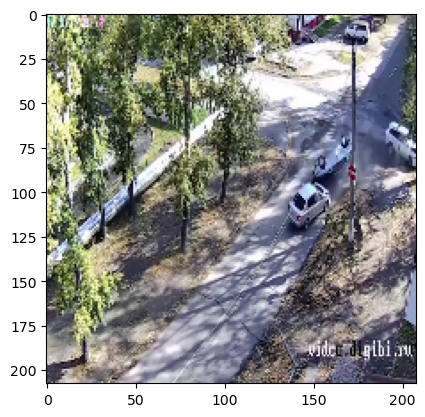

In [28]:
#Проверка
img_test_region = train_data[53]
test_region = tf.convert_to_tensor(img_test_region)
b,g,r=cv2.split(img_test_region)
test_region=cv2.merge((r,g,b)) 
plt.imshow(test_region)
plt.show()

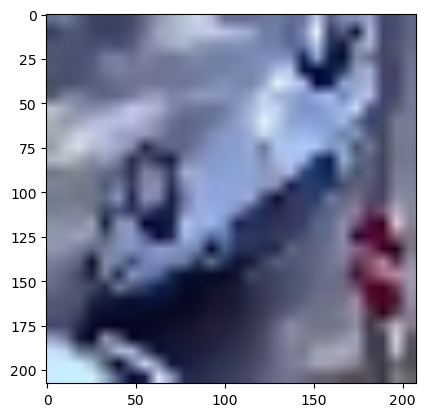

In [29]:
#Проверка
img_test_data = train_region[53]
test_data = tf.convert_to_tensor(img_test_data)
b,g,r=cv2.split(img_test_data)
test_region=cv2.merge((r,g,b)) 
plt.imshow(test_region)
plt.show()

In [19]:
train_class[53]

array([1, 0])

In [20]:
#классификация
history = model_class.fit(train_region, train_class, epochs = 60, batch_size = batch_size, validation_data = (val_region, val_class))
# #локализация
# history = model_loc.fit(train_data, train_coords, epochs = 500, batch_size = 32, validation_data = (val_data, val_coords))

Epoch 1/60
129/129 [==============================] - 78s 262ms/step - loss: 5.0611 - accuracy: 0.5400 - val_loss: 0.6391 - val_accuracy: 0.8200
Epoch 2/60
129/129 [==============================] - 21s 165ms/step - loss: 0.5263 - accuracy: 0.7594 - val_loss: 0.4641 - val_accuracy: 0.7665
Epoch 3/60
129/129 [==============================] - 19s 150ms/step - loss: 0.3627 - accuracy: 0.8545 - val_loss: 0.4010 - val_accuracy: 0.8181
Epoch 4/60
129/129 [==============================] - 21s 159ms/step - loss: 0.2633 - accuracy: 0.9005 - val_loss: 0.1947 - val_accuracy: 0.9319
Epoch 5/60
129/129 [==============================] - 21s 164ms/step - loss: 0.1561 - accuracy: 0.9448 - val_loss: 0.2944 - val_accuracy: 0.8696
Epoch 6/60
129/129 [==============================] - 23s 176ms/step - loss: 0.1066 - accuracy: 0.9616 - val_loss: 0.1326 - val_accuracy: 0.9416
Epoch 7/60
129/129 [==============================] - 24s 183ms/step - loss: 0.1192 - accuracy: 0.9628 - val_loss: 0.1538 - val_ac

In [21]:
model_class.save('Модели на тест\\car.h5')

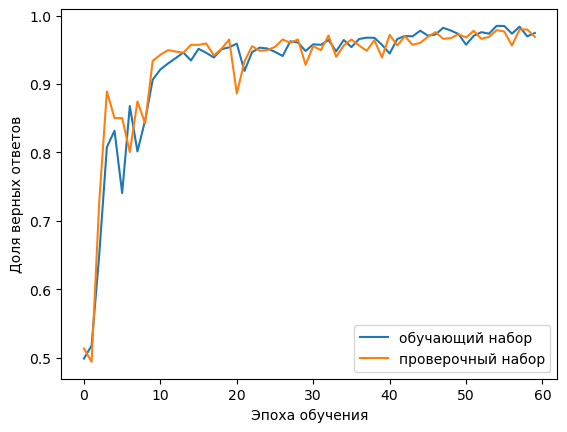

In [27]:
#Вывод графика
plt.plot(history.history['accuracy'],
         label='обучающий набор')
plt.plot(history.history['val_accuracy'],
         label='проверочный набор')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()
